# 5LSM0 Final Assignment: Cityscapes Challenge

For this final assignment, you're participating in the [Cityscapes Pixel-Level Segmentation Benchmark](https://www.cityscapes-dataset.com/benchmarks/#scene-labeling-task)! You will do this in **groups of two students**. The goal is to create a network that performs semantic segmentation on the Cityscapes dataset. This dataset is a large collection of pictures taken from the perspective of a driver in various German cities. Each picture has a corresponding ground-truth image, where each pixel is given a color that corresponds to the class of the object appearing in that pixel. The table below shows the expected input and output of the solution you will be creating.

<table>
<thead>
    <tr><th>Input</th><th>Output</th></tr>
</thead>
<tbody>
    <tr>
        <td>
            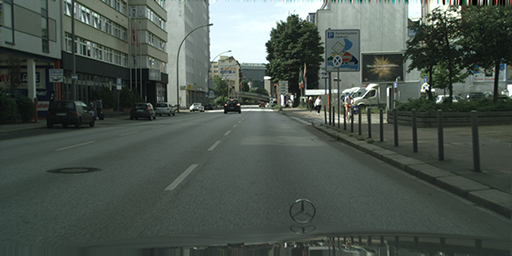
        </td>
        <td>
        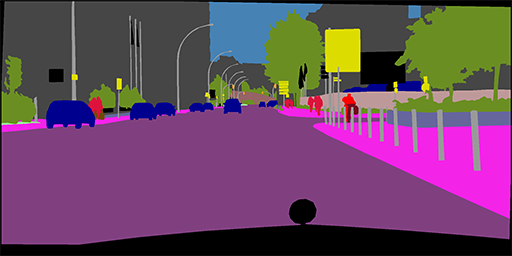
        </td>
    </tr>
    <tr>
        <td>Picture from the Cityscapes dataset.</td>
        <td>Semantic class assigned to each pixel. Every unique color corresponds to one class.</td>
    </tr>
</tbody>
</table>

Once you have a working solution, you can submit your output to the Cityscapes benchmark by creating an account and following [this link](https://www.cityscapes-dataset.com/submit/). We're excited to see where you will show up in the leaderboards!

Remember that this assignment determines 50% of your final grade. This amounts to **50 hours of active work** per student. Additionally, training your neural network will likely take many hours, take this into account when making your working schedule. This notebook downloads the required data for the benchmark and sets up a training pipeline so you can focus on creating networks using the skills you learned during this course. Some exercises have been included to get you started. Join us during computer class or message an assistant if you have any questions.

## Deliverables

Write a paper (one per group) in which you briefly introduce the problem, a baseline approach, your own addition(s), results and  conclusions. Use the **[IEEE double-column format](https://www.overleaf.com/latex/templates/ieee-conference-template/grfzhhncsfqn)** and **max. 4 pages**. You are allowed and expected to use ideas from literature and on the internet. Make sure you properly cite all the relevant sources in your paper. The assignment will be graded on paper quality, experimental setup, demonstrated insight and originality. What we at least expect is:

- Introduction to the problem: What are challenges? What are logical options to address them? What has been done for this or similar problems?
- Baseline implementation and results, using an off-the-shelf segmentation model.
- Improvements to that baseline, backed with experiments and results. Motivate your choices and explain your observations.
- Discussion on limitations and options to further improve.
- Clear and concise figures and tables to support your findings.

Submit your report and code to Canvas when you're finished.

## Requirements

You need at least Python version 3.7. The prefered library for creating your network is PyTorch. All third-party packages you need to run this notebook are imported below, such that you can install any missing dependencies before getting started.

In [1]:
import torch
import torchvision
import PIL
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

%matplotlib inline


## Downloading and preprocessing the ground truth and input files
Let's start with downloading a ZIP-file that contains the training, testing and validation datasets.

In [2]:
import os
import sys
import shutil
import tempfile

from urllib.request import urlretrieve

# Data directory. Change this to download to a different directory, e.g. to an external drive to save space. 
# You need 20 GB to store all data.
# If you use Google Colab to run this notebook, then you may want to point this to a Google Drive directory shared
# between you and your assignment partner.
dir_data = os.path.abspath("data")

# URLs to retrieve ground truth and images data from. 
url_truth = 'https://flux127120.nbw.tue.nl/index.php/s/Cwxa5Ft2pQBK9N7/download'
dir_truth = os.path.join(dir_data, "gtFine")

url_input = 'https://flux127120.nbw.tue.nl/index.php/s/Tz3GCjQwwsiHgqC/download'
dir_input = os.path.join(dir_data, "leftImg8bit")

# Download and extraction function
def download_extract(url: str):
    # Create a temp directory to download into
    with tempfile.TemporaryDirectory(dir=dir_data, prefix="download_") as dir_temp:
        print(f'Downloading: {url}')
        zip_path = os.path.join(dir_temp, 'download.zip')
        urlretrieve(url, zip_path, lambda n, size, total: sys.stdout.write(f'\rProgress: {n*size/total*100:.2f} %'))
        sys.stdout.write('\n')
        sys.stdout.flush()
        
        print(f'Unpacking archive.')
        shutil.unpack_archive(zip_path, dir_data)

# Create the data directory (if it does not exist)
os.makedirs(dir_data, exist_ok=True)

# Check if both the ground truth and input directories have been downloaded and extracted
for dir, url in [(dir_truth, url_truth), (dir_input, url_input)]:
    if not os.path.isdir(dir):
        # Download the required files
        print(f'Directory does not exist: {dir}')
        download_extract(url)
    else:
        print(f'Directory already downloaded: {dir}')
        
# Done!
print(f'All data downloaded')



Directory already downloaded: C:\Users\hanba\cvQ3\data\gtFine
Directory already downloaded: C:\Users\hanba\cvQ3\data\leftImg8bit
All data downloaded


The downloaded images are very large. A consumer-grade PC likely does not have enough GPU-memory or data bandwidth to create a viable implementation in the original size. For this reason, we run a pre-processing step on the dataset that downscales all images. Once you have a working model, you may consider using a larger `sample_size`.

In [3]:
from PIL import Image

# Target size of each sample in the dataset
sample_size = (256, 128)        # Used to be (256, 128)

# Directories for preprocessed datasets
dir_truth_pp, dir_input_pp = (f'{d}_{sample_size[0]}_{sample_size[1]}' for d in (dir_truth, dir_input))

# Current loop
num = 0     # default with start training loop = 0

# Run preprocessing
for dir_full, dir_pp in ((dir_truth, dir_truth_pp), (dir_input, dir_input_pp)):
    # Check if the directory already exists
    if os.path.isdir(dir_pp):
        print(f'Preprocessed directory already exists: {dir_pp}')
        continue
        
    print(f'Preprocessing: {dir_full}')
        
    # Walk though the directory and preprocess each file 
    for root,_,files in  os.walk( dir_full ):
        if len(files) == 0:
            continue
            
        print(f'Preprocessing sub-directory: {root.replace(dir_full, "")}')
        
        # Create the directory in the preprocessed set
        root_pp = root.replace(dir_full, dir_pp)
        os.makedirs(root_pp, exist_ok=True)
        
        for f in files:
            if not f.endswith('.png'):
                continue
            
            # Resize and save PNG image
            path_original = os.path.join(root,f)
            img_resized = Image.open(path_original).resize(sample_size, Image.NEAREST)
            img_resized.save(path_original.replace(dir_full, dir_pp), 'png', quality=100)
            
print(f'Preprocessing done')


Preprocessed directory already exists: C:\Users\hanba\cvQ3\data\gtFine_256_128
Preprocessed directory already exists: C:\Users\hanba\cvQ3\data\leftImg8bit_256_128
Preprocessing done


## Data structures

Now that our data has been downloaded, we can proceed to define some data structures to model the structure of the provided data. Each semantic class that we aim to detect has a unique name, id and color. For more information on the datset, view [this link](https://www.cityscapes-dataset.com/dataset-overview/).

In [4]:
from dataclasses import dataclass
from typing import Tuple
import re

# Each sample we downloaded can be identified by the name of the city as well as a frame and sequence id
@dataclass
class CityscapesSample:
    city: str
    seq_id: str
    frame_id: str
    
    @property  # Using getter and setter to realize attribute operation 
    def id(self):
        # Without define setter, it is read-only arrtibute
        return os.path.join(self.city, "_".join([self.city, self.seq_id, self.frame_id]))
    
    @staticmethod
    def from_filename(filename: str):
        # Create a CityscapesSample from a filename, which has a fixed structure {city}_{sequence}_{frame}
        match = re.match(r"^(\w+)_(\d+)_(\d+).*.png$", filename, re.I)  # Find the filename at start and ignore upper/lower case
        return CityscapesSample(match.group(1), match.group(2), match.group(3))
            
    
# Each class that we aim to detect is assigned a name, id and color.
@dataclass
class CityscapesClass:
    name: str
    id: int
    color: Tuple[int, int, int]

# List of classes that we want to detect in the input
classes = [
    CityscapesClass('void', 0, (0, 0, 0)),
    CityscapesClass('dynamic', 1, (111, 74, 0)),
    CityscapesClass('ground', 2, (81, 0, 81)),
    CityscapesClass('road', 3, (128, 64, 128)),
    CityscapesClass('sidewalk', 4, (244, 35, 232)),
    CityscapesClass('parking', 5, (250, 170, 160)),
    CityscapesClass('rail track', 6, (230, 150, 140)),
    CityscapesClass('building', 7, (70, 70, 70)),
    CityscapesClass('wall', 8, (102, 102, 156)),
    CityscapesClass('fence', 9, (190, 153, 153)),
    CityscapesClass('guard rail', 10, (180, 165, 180)),
    CityscapesClass('bridge', 11, (150, 100, 100)),
    CityscapesClass('tunnel', 12, (150, 120, 90)),
    CityscapesClass('pole', 13, (153, 153, 153)),
    CityscapesClass('polegroup', 14, (153, 153, 153)),
    CityscapesClass('traffic light', 15, (250, 170, 30)),
    CityscapesClass('traffic sign', 16, (220, 220, 0)),
    CityscapesClass('vegetation', 17, (107, 142, 35)),
    CityscapesClass('terrain', 18, (152, 251, 152)),
    CityscapesClass('sky', 19, (70, 130, 180)),
    CityscapesClass('person', 20, (220, 20, 60)),
    CityscapesClass('rider', 21, (255, 0, 0)),
    CityscapesClass('car', 22, (0, 0, 142)),
    CityscapesClass('truck', 23, (0, 0, 70)),
    CityscapesClass('bus', 24, (0, 60, 100)),
    CityscapesClass('caravan', 25, (0, 0, 90)),
    CityscapesClass('trailer', 26, (0, 0, 110)),
    CityscapesClass('train', 27, (0, 80, 100)),
    CityscapesClass('motorcycle', 28, (0, 0, 230)),
    CityscapesClass('bicycle', 29, (119, 11, 32)),
]


## Dataset implementation

This section implements a [PyTorch Dataset](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html). It transforms image and target colorization pairs from the downloaded files into pairs of input and ground truth tensors. The ground truths are single-channel images where the value of each pixel is equal to the ID of the class represented by the color in the target. This will enable us to train the network using cross-entropy. 

In [28]:
import numpy as np

from torch.utils.data import Dataset
from PIL import Image
from typing import Dict, Optional, Tuple, List, Union  # import Union for type hints

import torchvision.transforms.functional as TF

# Create a custom Dataset class
class CityscapesDataset(Dataset):
    # Regular expression matching each PNG file in the dataset
    __read_reg = r"^(\w+)_(\d+)_(\d+).*.png$"
    
    ########## Main Custom Dateset Frame ##########
    def __init__(self, dir_input: str, dir_truth: str, sample_size: Tuple[int,int], classes: List[CityscapesSample], num: int):
        super().__init__()  # Inherit parent class Dataset
        
        # These variables are also available as globals, but it is good practice to make classes
        # not depend on global variables.
        self.dir_input = dir_input
        self.dir_truth = dir_truth
        self.sample_size = sample_size
        self.classes = classes
        self.num = num

        # Walk through the inputs directory and add each file to our items list
        self.items = []
        for (_, _, filenames) in os.walk(self.dir_input):
            self.items.extend([CityscapesSample.from_filename(f) for f in filenames])

        # Sanity check: do the provided directories contain any samples?
        assert len(self.items) > 0, f"No items found in {self.dir_input}"

    def __len__(self):
        return len(self.items)

    def __getitem__(self, i: int) -> Union[torch.Tensor, torch.Tensor]:
        sample = self.items[i]

        input = self.load_input(sample)
        truth = self.load_truth(sample)

        return self.transform(input, truth)  # Tensor transform with data augmentations
    ##############################################
    
    def load_input(self, sample: CityscapesSample) -> Image:
        path = os.path.join(self.dir_input, f'{sample.id}_leftImg8bit.png')
        return Image.open(path).convert("RGB").resize(self.sample_size, Image.NEAREST)

    def load_truth(self, sample:CityscapesSample) -> Image:
        path = os.path.join(self.dir_truth, f'{sample.id}_gtFine_color.png')
        return Image.open(path).convert("RGB").resize(self.sample_size, Image.NEAREST)

    def transform(self, img: Image.Image, mask: Optional[Image.Image]) -> Union[torch.Tensor, torch.Tensor]:    # mask = truth
        
        ################################################################################# 
         ## EXERCISE #####################################################################
        #
        # Data augmentation is a way to improve the accuracy of a model.
        #
        # Once you have a model that works, you can implement some data augmentation 
        # techniques here to further improve performance.
        #
        ##################################################################################
        if(self.dir_input == os.path.join(dir_input_pp, 'train')):
            if(self.num % 5 == 0):  # Training with raw data every five epochs
                # Raw data
                # print("Now using raw data")
                pass
            else:
                choice = random.random()
                if choice <= 0.3:
                    whichrand = random.random() 
                    if whichrand <= 0.5:
                        # ColorJitter
                        # print("Now using color jitter data")
                        img = torchvision.transforms.ColorJitter(brightness=0.5)(img)
                    else:
                        # Horizontal Flip
                        # print("Now using horizontal flip data")
                        img = torchvision.transforms.RandomHorizontalFlip(p=1)(img)
                        mask = torchvision.transforms.RandomHorizontalFlip(p=1)(mask)
                else:
                    # Raw data
                    # print("Now using raw data")
                    pass

        # Convert the image to a tensor
        img = TF.to_tensor(img)

        # If no mask is provided, then return only the image
        if mask is None:
            return img, None

        # Transform the mask from an image with RGB-colors to an 1-channel image with the index of the class as value
        mask_size = [s for s in self.sample_size]
        mask = torch.from_numpy(np.array(mask)).permute((2,0,1))
        target = torch.zeros((mask_size[1], mask_size[0]), dtype=torch.uint8)
        for i,c in enumerate(classes):
            eq = mask[0].eq(c.color[0]) & mask[1].eq(c.color[1]) & mask[2].eq(c.color[2])
            target += eq * i

        return img, target

    def masks_to_indices(self, masks: torch.Tensor) -> torch.Tensor:
        _, indices = masks.softmax(dim=1).max(dim=1)
        return indices

    def to_image(self, indices: torch.Tensor) -> Image.Image:
        target = torch.zeros((3, indices.shape[0], indices.shape[1]),
                             dtype=torch.uint8, device=indices.device, requires_grad=False)

        for i, lbl in enumerate(self.classes):
            eq = indices.eq(i)

            target[0] += eq * lbl.color[0]
            target[1] += eq * lbl.color[1]
            target[2] += eq * lbl.color[2]

        return TF.to_pil_image(target.cpu(), 'RGB')
    
# Create one instance of the CityscapesDataset for each split type
ds_split = {
    name:CityscapesDataset(os.path.join(dir_input_pp, name), os.path.join(dir_truth_pp, name), sample_size, classes, num)    # Seperate 2 elements by : (claim operator)
    for name in ("train", "val", "test")    # Claim the variable name belongs to object CityscapeDataset first and then create when the values are assigned
}
print(os.path.join(dir_input_pp, 'train'))
print(os.path.join(dir_truth_pp, 'train'))

C:\Users\hanba\cvQ3\data\leftImg8bit_256_128\train
C:\Users\hanba\cvQ3\data\gtFine_256_128\train


The Cityscapes dataset is split in three parts: `train`, `val` and `test`. If everything is set-up correctly, we should be able to draw a random sample from each split, convert it back to an image, and display it.

Subset,Amount,Size,Input sample,Truth sample
train,2975,256×128,,
val,500,256×128,,
test,1525,256×128,,

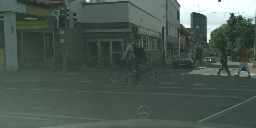
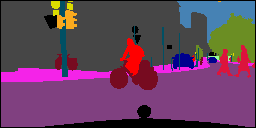
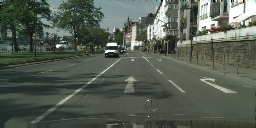
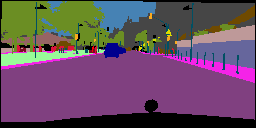
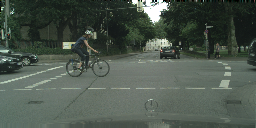
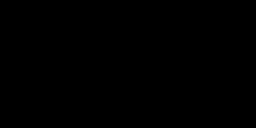

In [29]:
from IPython.display import display, HTML
from io import BytesIO
from base64 import b64encode

import random

# HTML templates for displaying random samples in a table
template_table = '<table><thead><tr><th>Subset</th><th>Amount</th><th>Size</th><th>Input sample</th><th>Truth sample</th></tr></thead><tbody>{0}</tbody></table>'
template_row = '<tr><td>{0}</td><td>{1}</td><td>{2}</td><td>{3}</td><td>{4}</td></tr>'
template_img = '<img src="data:image/png;base64,{0}"/>'

# Display a random sample of each split of the dataset
rows = []
for name, ds_sub in ds_split.items():    # dict.items() can return Tuple one by one in the dictionary
    # Draw a random sample from the dataset so that we can convert it back to an image
    input, truth = random.choice(ds_sub)
    
    input = TF.to_pil_image(input)
    truth = ds_sub.to_image(truth)  # Self-defined function
    
    # Create a buffer to save each retrieved image into such that we can base64-encode it for diplay in our HTML table
    with BytesIO() as buffer_input, BytesIO() as buffer_truth: 
        input.save(buffer_input, format='png')
        truth.save(buffer_truth, format='png')

        # Store one row of the dataset
        images = [template_img.format(b64encode(b.getvalue()).decode('utf-8')) for b in (buffer_input, buffer_truth)]
        rows.append(template_row.format(name, len(ds_sub), '&times;'.join([str(s) for s in input.size]), *images))

# Render HTML table
table = template_table.format(''.join(rows))
display(HTML(table))


Notice that the `test` set has no ground truth labels, as this is the set used to score competitors' networks against each other. If you submit the best network that you have created to the Cityscapes competition, this is the set that is used to calculate your score.

## Calculating accuracy
Your score on the benchmark will be calculated according to the the intersection-over-union (IoU) metric. [This link](https://www.cityscapes-dataset.com/benchmarks/#scene-labeling-task) describes how it is implemented in the testing suite. 

The function below is thus a measure for the accuracy of your solution. The `output` parameter represents the output of your network: a batch of multi-dimensional images with one channel per class. For every pixel, the class ID can be calculated by taking the index of the channel containing the maximum value. The `truths` parameter is a batch of ground truths from the `CityscapesDataset` defined above.

In [22]:
def compute_iou(output: torch.Tensor, truths: torch.Tensor) -> float:
    output = output.detach()    # Returns a new Tensor, detached from the current graph
    truths = truths.detach()

    ## EXERCISE #####################################################################
    #
    # Implement the IoU metric that is used by the benchmark to grade your results.
    #     
    # `output` is a tensor of dimensions [Batch, Classes, Height, Width]
    # `truths` is a tensor of dimensions [Batch, Height, Width]
    #
    # Tip: Peform a sanity check that tests your implementation on a user-defined 
    #      tensor for which you know what the output should be.
    #
    ################################################################################# 
    # # Sanity check of output tensor
    # assert(
    #     len(output.size()) == 4,
    #     output.size(dim=0) == truths.size(dim=0),
    #     output.size(dim=1) == len(classes),
    #     output.size(dim=2) == truths.size(dim=1),
    #     output.size(dim=3) == truths.size(dim=2),
    #     f"Output is not in the right shape"   
    # )
    
    

    ##################### IoU = TP / (TP + FP + FN) ####################
    # 
    # True Positive, TP: truth = TRUE and prediction = TRUE
    # False Positive, FP: truth = FALSE and prediction = TRUE
    # False Negative, FN: truth = TRUE and prediction = FALSE
    # True Negative, TN: truth = FALSE and prediction = FALSE   
    #
    #####################################################################

    # Method 1: Calculate different classes seperately

    # # Reshape output tensor from [Batch, Classes, Height, Width] to [Batch, Height, Width]
    # # by extracting the most possible class
    # output_class = torch.argmax(output, dim=1)      # prediction

    # # N-ary classification
    # TP = []     # TP of different classes -> [Classes, BatchSize, Flatten matched pixels per class]
    # FP = []
    # FN = []
    # for i in range(1, len(classes)):           # Class loop
    #     # Binary classification
    #     TP.append(torch.logical_and(torch.eq(truths, i), torch.eq(output_class, i)).tolist())    # [BatchSize, Width, Height]
    #     FP.append(torch.logical_and(~torch.eq(truths, i), torch.eq(output_class, i)).tolist())
    #     FN.append(torch.logical_and(torch.eq(truths, i), ~torch.eq(output_class, i)).tolist())
    # # Tranpose and reshape again from [Classes, BatchSize, Flatten matched pixels per class] -> [BatchSize, Classes * Flatten matched pixels per classes]
    # TP = np.transpose(TP, (1, 0, 2, 3))
    # FP = np.transpose(FP, (1, 0, 2, 3))
    # FN = np.transpose(FN, (1, 0, 2, 3))
    # TP = np.reshape(TP, (len(TP), -1))
    # FP = np.reshape(FP, (len(FP), -1))
    # FN = np.reshape(FN, (len(FN), -1))
    # # IoU of different Batches -> [BatchSize]
    # iou = np.count_nonzero(TP, axis=1) / (np.count_nonzero(TP, axis=1) + np.count_nonzero(FP, axis=1) + np.count_nonzero(FN, axis=1))   
    # iou = np.nansum(iou) / len(iou)


    # Method 2: Another faster way with one-hot extension 

    output = F.one_hot(torch.argmax(output, dim=1), num_classes=len(classes)).contiguous()
    truths_onehot = F.one_hot(truths, num_classes=len(classes)).contiguous()

    output = output[:,:,:,1:30]
    truths_onehot = truths_onehot[:,:,:,1:30]

    TP = (output*truths_onehot).reshape([len(output),-1])
    FPFN = (output-truths_onehot).reshape([len(output),-1])

    iou = torch.count_nonzero(TP, dim=1) / (torch.count_nonzero(TP, dim=1) + torch.count_nonzero(FPFN, dim=1))
    iou = torch.sum(iou) / len(iou)
    

    # # Sanity check of the value of IoU
    # assert(
    #     iou >= 0 and iou <= 1,
    #     f"IoU is not between 0 to 1, got: {iou}"
    # )
    #################################################################################
    
    return iou

## Training setup
The final step before you can implement your networks is to define the training process.

In [23]:
from torch import nn, optim
from torch.utils.data import DataLoader


class Trainer:
    def __init__(self, model: nn.Module, ds_split: Dict[str,CityscapesDataset]):
        # Choose a device to run training on. Ideally, you have a GPU available to accelerate the training process.
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        print(self.device)
        # self.device = "cpu"
                
        # Move the model onto the target device
        self.model = model.to(self.device)
        
        # Store the dataset split
        self.ds_split = ds_split
        
        ## EXERCISE #####################################################################
        #
        # Select an optimizer
        #
        # See: https://pytorch.org/docs/stable/optim.html
        #
        ################################################################################# 
        
        self.optimizer = optim.Adam(model.parameters(), lr=0.0015)
        #self.optimizer = optim.SGD(model.parameters(), lr=0.001,momentum=0.9)
        
        
        ## EXERCISE #####################################################################
        #
        # Select an appropriate loss function
        #
        # See: https://pytorch.org/docs/stable/nn.html#loss-functions
        #
        ################################################################################# 
        
        self.critereon = nn.CrossEntropyLoss()
        
        ################################################################################# 
        
        assert self.critereon is not None, "You have not defined a loss"
        assert self.optimizer is not None, "You have not defined an optimizer"
        
    def train_epoch(self, dl:DataLoader):
        # Put the model in training mode
        self.model.train()
        
        # Store each step's accuracy and loss for this epoch
        epoch_metrics = {
            "loss": [],
            "accuracy": []
        }
        
        # Create a progress bar using TQDM
        sys.stdout.flush()
        with tqdm(total=len(self.ds_split["train"]), desc=f'Training') as pbar:
            # Iterate over the training dataset
            for inputs, truths in dl:
                # Zero the gradients from the previous step
                self.optimizer.zero_grad()
                
                # Move the inputs and truths to the target device
                inputs = inputs.to(device=self.device, dtype=torch.float32)
                inputs.required_grad = True  # Fix for older PyTorch versions
                truths = truths.to(device=self.device, dtype=torch.long)
                
                # Run model on the inputs
                output = self.model(inputs)

                # Perform backpropagation
                loss = self.critereon(output, truths)
                loss.backward()
                nn.utils.clip_grad_value_(model.parameters(), 0.1)
                self.optimizer.step()
                
                
                
                # Store the metrics of this step
                step_metrics = {
                    'loss': loss.item(),
                    'accuracy': compute_iou(output, truths)
                }
                
                # Update the progress bar
                pbar.set_postfix(**step_metrics)
                pbar.update(list(inputs.shape)[0])
                
                # Add to epoch's metrics
                for k,v in step_metrics.items():
                    epoch_metrics[k].append(v)
                    
            
        sys.stdout.flush()
        
        # Return metrics
        return epoch_metrics
    
    def val_epoch(self, dl:DataLoader):
        # Put the model in evaluation mode
        self.model.eval()
        
        # Store the total loss and accuracy over the epoch
        amount = 0
        total_loss = 0
        total_accuracy = 0
        
        # Create a progress bar using TQDM
        sys.stdout.flush()
        with torch.no_grad(), tqdm(total=len(self.ds_split["val"]), desc=f'Validation') as pbar:
            # Iterate over the validation dataloader
            for inputs, truths in dl:
                 # Move the inputs and truths to the target device
                inputs = inputs.to(device=self.device, dtype=torch.float32)
                inputs.required_grad = True  # Fix for older PyTorch versions
                truths = truths.to(device=self.device, dtype=torch.long)

                # Run model on the inputs
                output = self.model(inputs)
                loss = self.critereon(output, truths)

                # Store the metrics of this step
                step_metrics = {
                    'loss': loss.item(),
                    'accuracy': compute_iou(output, truths)
                }

                # Update the progress bar
                pbar.set_postfix(**step_metrics)
                pbar.update(list(inputs.shape)[0])

                amount += 1
                total_loss += step_metrics["loss"]
                total_accuracy += step_metrics["accuracy"]
        sys.stdout.flush()
        
        # Print mean of metrics
        total_loss /= amount
        total_accuracy /= amount
        print(f'Validation loss is {total_loss/amount}, validation accuracy is {total_accuracy}')
              
        # Return mean loss and accuracy
        return {
            "loss": [total_loss],
            "accuracy": [total_accuracy]
        }
            
        
    def fit(self, epochs: int, batch_size:int):
        # Initialize Dataloaders for the `train` and `val` splits of the dataset. 
        # A Dataloader loads a batch of samples from the each dataset split and concatenates these samples into a batch.
        dl_train = DataLoader(ds_split["train"], batch_size=batch_size, shuffle=True)
        dl_val = DataLoader(ds_split["val"], batch_size=batch_size, drop_last=True)
                
        # Store metrics of the training process (plot this to gain insight)
        df_train = pd.DataFrame()
        df_val = pd.DataFrame()
        
        # Train the model for the provided amount of epochs
        for epoch in range(1, epochs+1):
            if os.path.join(os.path.abspath('./modeltrained'), 'network.pt') == True:
                self.model = torch.load(os.path.join(os.path.abspath('./modeltrained'), 'network.pt'))
            print(f'Epoch {epoch}')
            metrics_train = self.train_epoch(dl_train)
            df_train = df_train.append(pd.DataFrame({'epoch': [epoch for _ in range(len(metrics_train["loss"]))], **metrics_train}), ignore_index=True)
            
            metrics_val = self.val_epoch(dl_val)            
            df_val = df_val.append(pd.DataFrame({'epoch': [epoch], **metrics_val}), ignore_index=True)
            
            torch.save(self.model,os.path.join(os.path.abspath('./modeltrained'), 'network.pt'))
        # Return a dataframe that logs the training process. This can be exported to a CSV or plotted directly.
        return df_train, df_val


We can do a quick sanity check by creating a pass-through network that transforms the expected input shape into the output shape. While we don't expect this to solve the semantic segmentation problem, it does provide a way to test whether the inputs, truths and outputs are passed through the `Trainer` class correctly.

In [24]:
from torch import nn
import torch.nn.functional as F

# Define a module that transforms: RGB-channel image -> len(classes)-channel image
class Passthrough(nn.Module):
    def __init__(self, n_channels=3, n_classes=len(classes)):
        super().__init__()
        
        self.transform = nn.Conv2d(n_channels, n_classes, 1)
        
    def forward(self, x):
        x = F.softmax(self.transform(x), dim=1)
        return x
    


If the section above ran without errors, then you are ready to continue.

## Define a baseline
You should start by implementing a network that performs semantic segmentation reasonably well (e.g. [U-Net](https://arxiv.org/pdf/1505.04597.pdf)). This will be the baseline against which you can compare your own improvements.

In [28]:
# Define a baseline from literature
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch), 
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
 
    def forward(self, input):
        return self.conv(input)

class Unet(nn.Module):
    def __init__(self, in_ch=3, out_ch=30):
        super(Unet, self).__init__()
        self.conv1 = DoubleConv(in_ch, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.conv4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        self.conv5 = DoubleConv(512, 1024)
     
        self.up6 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.conv6 = DoubleConv(1024, 512)
        self.up7 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv7 = DoubleConv(512, 256)
        self.up8 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv8 = DoubleConv(256, 128)
        self.up9 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv9 = DoubleConv(128, 64)
        self.conv10 = nn.Conv2d(64, out_ch, 1)
 
    def forward(self, x):
        c1 = self.conv1(x)
        p1 = self.pool1(c1)
        c2 = self.conv2(p1)
        p2 = self.pool2(c2)
        c3 = self.conv3(p2)
        p3 = self.pool3(c3)
        c4 = self.conv4(p3)
        p4 = self.pool4(c4)
        c5 = self.conv5(p4)
        up_6 = self.up6(c5)
        merge6 = torch.cat([up_6, c4], dim=1)
        c6 = self.conv6(merge6)
        up_7 = self.up7(c6)
        merge7 = torch.cat([up_7, c3], dim=1)
        c7 = self.conv7(merge7)
        up_8 = self.up8(c7)
        merge8 = torch.cat([up_8, c2], dim=1)
        c8 = self.conv8(merge8)
        up_9 = self.up9(c8)
        merge9 = torch.cat([up_9, c1], dim=1)
        c9 = self.conv9(merge9)
        c10 = self.conv10(c9)
        out = c10
        return out

Testing training process...
cuda
Epoch 1


Validation: 100%|██████████████| 500/500 [00:35<00:00, 14.06it/s, accuracy=tensor(0.7307, device='cuda:0'), loss=0.608]


Validation loss is 0.015481473410129547, validation accuracy is 0.6486721038818359
Epoch 2


Validation: 100%|██████████████| 500/500 [00:11<00:00, 44.12it/s, accuracy=tensor(0.7270, device='cuda:0'), loss=0.562]


Validation loss is 0.014098926901817322, validation accuracy is 0.6656633615493774
cuda
Epoch 1


Validation: 100%|██████████████| 500/500 [00:11<00:00, 44.23it/s, accuracy=tensor(0.7635, device='cuda:0'), loss=0.473]

Validation loss is 0.013436783289909361, validation accuracy is 0.6924011707305908
Epoch 2



Validation: 100%|██████████████| 500/500 [00:11<00:00, 43.89it/s, accuracy=tensor(0.7719, device='cuda:0'), loss=0.461]


Validation loss is 0.012060878384113311, validation accuracy is 0.7098820805549622
cuda
Epoch 1


Validation: 100%|██████████████| 500/500 [00:11<00:00, 43.79it/s, accuracy=tensor(0.7711, device='cuda:0'), loss=0.465]


Validation loss is 0.012702762258052827, validation accuracy is 0.700660228729248
Epoch 2


Validation: 100%|██████████████| 500/500 [00:11<00:00, 44.08it/s, accuracy=tensor(0.7863, device='cuda:0'), loss=0.426]


Validation loss is 0.011186838006973267, validation accuracy is 0.7282540798187256
cuda
Epoch 1


Validation: 100%|████████████████| 500/500 [00:11<00:00, 43.95it/s, accuracy=tensor(0.7956, device='cuda:0'), loss=0.4]


Validation loss is 0.010620310747623443, validation accuracy is 0.7357731461524963
Epoch 2


Validation: 100%|██████████████| 500/500 [00:11<00:00, 44.04it/s, accuracy=tensor(0.7346, device='cuda:0'), loss=0.535]


Validation loss is 0.011895342826843262, validation accuracy is 0.7078643441200256
cuda
Epoch 1


Validation: 100%|███████████████| 500/500 [00:11<00:00, 43.76it/s, accuracy=tensor(0.7906, device='cuda:0'), loss=0.39]


Validation loss is 0.010063926768302917, validation accuracy is 0.745858371257782
Epoch 2


Validation: 100%|███████████████| 500/500 [00:11<00:00, 43.84it/s, accuracy=tensor(0.7954, device='cuda:0'), loss=0.39]


Validation loss is 0.0102908172249794, validation accuracy is 0.7312503457069397


Tensor,Shape,Image
Input,"[3, 128, 256]",
Output,"[1, 30, 128, 256]",
Target,"[128, 256]",

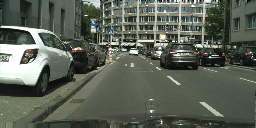
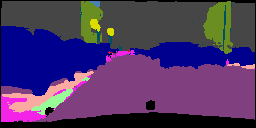
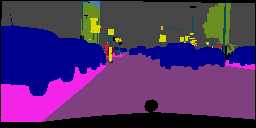

In [29]:
# Baseline model only with augmentation
import time
torch.cuda.empty_cache()
time.sleep(3)

model = Unet()
    
# Train the passthrough network
print("Testing training process...")
for i in range(5):
    # Re-create dataset and re-train
    ds_split = {
        name:CityscapesDataset(os.path.join(dir_input_pp, name), os.path.join(dir_truth_pp, name), sample_size, classes, i)    # Seperate 2 elements by : (claim operator)
        for name in ("train", "val", "test")    # Claim the variable name belongs to object CityscapeDataset first and then create when the values are assigned 
    }
    trainer = Trainer(model, ds_split)
    trainer.fit(epochs=2, batch_size=10)

# Draw a random sample
input, truth = random.choice(ds_split["val"])

# Push through our network
model = model.cpu()
output = model(input.unsqueeze(0))

# Display the input, output and truth tensors
template_table = '<table><thead><tr><th>Tensor</th><th>Shape</th><th>Image</th></tr></thead><tbody>{0}</tbody></table>'
template_row = '<tr><td>{0}</td><td>{1}</td><td><img src="data:image/png;base64,{2}"/></td></tr>'

input_img = TF.to_pil_image(input)
output_img = ds_split["val"].to_image(ds_split["val"].masks_to_indices(output).squeeze(0))
truth_img = ds_split["val"].to_image(truth)

rows = []
for name, tensor, img in [('Input', input, input_img), ('Output', output, output_img), ('Target', truth, truth_img)]:
    with BytesIO() as b: 
        img.save(b, format='png')
        rows.append(template_row.format(name, list(tensor.shape), b64encode(b.getvalue()).decode('utf-8')))

# Render HTML table
table = template_table.format(''.join(rows))
display(HTML(table))

## Create your own network
You can now start building upon your baseline network to improve accuracy on the validation dataset. Some directions that you should explore are:
- Data augmentation (see exercise in the `CityscapesDataset` class)
- Model architecture changes
- Hyperparameter tuning

Remember to save data and figures for your paper, and clearly explain your design choices.

In [11]:
class Conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(Conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch), 
            nn.ReLU(inplace=True),
#             nn.Conv2d(out_ch, out_ch, 3, padding=1),
#             nn.BatchNorm2d(out_ch),
#             nn.ReLU(inplace=True)          
        )
 
    def forward(self, input):
        return self.conv(input)


    
class Unetupgrade(nn.Module):
    def __init__(self, in_ch=3, out_ch=30):
        super(Unetupgrade, self).__init__()
        self.conv1 = Conv(in_ch, 64)#(256*128*3=>256*128*64)
        self.pool1 = nn.MaxPool2d(2)#(256*128*64=>128*64*64)
        self.conv2 = Conv(64, 128)#(128*64*64=>128*64*128)
        self.pool2 = nn.MaxPool2d(2)#128*64*128=>64*32*128
        self.conv3 = Conv(128, 256)#64*32*128=>64*32*256
        self.pool3 = nn.MaxPool2d(2)#64*32*256=>32*16*256
        self.conv4 = Conv(256, 1024)#32*16*256=>32*16*1024
        
        #self.pool4 = nn.MaxPool2d(2)#32*16*512=>16*8*512
        #self.conv5 = DoubleConv(512, 1024)#16*8*512=>16*8*1024
        ################
        self.up6 = nn.ConvTranspose2d(1024, 256, 2, stride=2)#32*16*1024=>64*32*256
        self.conv6 = Conv(512, 256)   
        self.up7 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv7 = Conv(256, 128)
        self.up8 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv8 = Conv(128, 64)
        #self.up9 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        #self.conv9 = DoubleConv(128, 64)
        self.conv9 = nn.Conv2d(64, out_ch, 1)
 
    def forward(self, x):
        c1 = self.conv1(x)
        p1 = self.pool1(c1)
        c2 = self.conv2(p1)
        p2 = self.pool2(c2)
        c3 = self.conv3(p2)#64*32*256
        p3 = self.pool3(c3)
        c4 = self.conv4(p3)
        #p4 = self.pool4(c4)
        #c5 = self.conv5(p4)
        up_6 = self.up6(c4)#32*16*1024=>64*32*256
        merge6 = torch.cat([up_6, c3], dim=1)#64*32*256 + 64*32*256=64*32*512
        c6 = self.conv6(merge6) #64*32*512=>64*32*256
        up_7 = self.up7(c6)#64*32*256=>128*64*128
        merge7 = torch.cat([up_7, c2], dim=1)#128*64*128+128*64*128=128*64*256
        c7 = self.conv7(merge7)#128*64*256=>128*64*128
        up_8 = self.up8(c7)#128*64*128=>256*128*64
        merge8 = torch.cat([up_8, c1], dim=1)#256*128*64+256*128*64=256*128*128
        c8 = self.conv8(merge8)#256*128*128=>256*128*64
        #up_9 = self.up9(c8)
        #merge9 = torch.cat([up_9, c1], dim=1)
        #c9 = self.conv9(merge9)
        c10 = self.conv9(c8)#256*128*64=>256*128*30
        out = c10
        return out

Testing training process...
cuda
Epoch 1


Validation: 100%|██████████████| 500/500 [00:10<00:00, 49.80it/s, accuracy=tensor(0.7167, device='cuda:0'), loss=0.648]

Validation loss is 0.016481292390823365, validation accuracy is 0.6352234482765198
Epoch 2



Validation: 100%|██████████████| 500/500 [00:09<00:00, 50.10it/s, accuracy=tensor(0.7240, device='cuda:0'), loss=0.614]

Validation loss is 0.015410791563987732, validation accuracy is 0.6523754596710205
cuda
Epoch 1



Validation: 100%|██████████████| 500/500 [00:10<00:00, 49.84it/s, accuracy=tensor(0.6974, device='cuda:0'), loss=0.613]

Validation loss is 0.015358348321914673, validation accuracy is 0.6470703482627869
Epoch 2



Validation: 100%|██████████████| 500/500 [00:10<00:00, 49.81it/s, accuracy=tensor(0.7178, device='cuda:0'), loss=0.578]

Validation loss is 0.015372578692436219, validation accuracy is 0.6533865332603455
cuda
Epoch 1



Validation: 100%|██████████████| 500/500 [00:10<00:00, 49.87it/s, accuracy=tensor(0.7323, device='cuda:0'), loss=0.522]

Validation loss is 0.01453664253950119, validation accuracy is 0.6448698043823242
Epoch 2



Validation: 100%|███████████████| 500/500 [00:09<00:00, 50.28it/s, accuracy=tensor(0.7449, device='cuda:0'), loss=0.52]

Validation loss is 0.013692245364189148, validation accuracy is 0.6829240322113037
cuda
Epoch 1



Validation: 100%|██████████████| 500/500 [00:10<00:00, 49.92it/s, accuracy=tensor(0.7131, device='cuda:0'), loss=0.556]

Validation loss is 0.014259124314785003, validation accuracy is 0.6582557559013367
Epoch 2



Validation: 100%|██████████████| 500/500 [00:09<00:00, 50.10it/s, accuracy=tensor(0.7438, device='cuda:0'), loss=0.493]

Validation loss is 0.012875736522674562, validation accuracy is 0.6801559925079346
cuda
Epoch 1



Validation: 100%|██████████████| 500/500 [00:10<00:00, 49.99it/s, accuracy=tensor(0.7400, device='cuda:0'), loss=0.509]

Validation loss is 0.012507653105258943, validation accuracy is 0.699574887752533
Epoch 2



Validation: 100%|██████████████| 500/500 [00:09<00:00, 50.14it/s, accuracy=tensor(0.6788, device='cuda:0'), loss=0.648]

Validation loss is 0.013576437318325044, validation accuracy is 0.6717820763587952
cuda
Epoch 1



Validation: 100%|██████████████| 500/500 [00:10<00:00, 49.88it/s, accuracy=tensor(0.7821, device='cuda:0'), loss=0.426]

Validation loss is 0.010880575072765351, validation accuracy is 0.7259507775306702
Epoch 2



Validation: 100%|██████████████| 500/500 [00:10<00:00, 49.65it/s, accuracy=tensor(0.7686, device='cuda:0'), loss=0.465]

Validation loss is 0.011359219872951506, validation accuracy is 0.7124269604682922
cuda
Epoch 1



Validation: 100%|██████████████| 500/500 [00:10<00:00, 49.72it/s, accuracy=tensor(0.7754, device='cuda:0'), loss=0.431]

Validation loss is 0.011413509976863861, validation accuracy is 0.7160467505455017
Epoch 2



Validation: 100%|██████████████| 500/500 [00:10<00:00, 49.76it/s, accuracy=tensor(0.7380, device='cuda:0'), loss=0.495]

Validation loss is 0.012089350616931916, validation accuracy is 0.6977307200431824
cuda
Epoch 1



Validation: 100%|██████████████| 500/500 [00:09<00:00, 50.24it/s, accuracy=tensor(0.6483, device='cuda:0'), loss=0.689]

Validation loss is 0.015573097991943358, validation accuracy is 0.6222283244132996
Epoch 2



Validation: 100%|██████████████| 500/500 [00:09<00:00, 50.20it/s, accuracy=tensor(0.7793, device='cuda:0'), loss=0.428]

Validation loss is 0.011561396384239198, validation accuracy is 0.7149022221565247
cuda
Epoch 1



Validation: 100%|███████████████| 500/500 [00:09<00:00, 50.31it/s, accuracy=tensor(0.7543, device='cuda:0'), loss=0.46]

Validation loss is 0.011735140919685362, validation accuracy is 0.7111442685127258
Epoch 2



Validation: 100%|██████████████| 500/500 [00:09<00:00, 50.03it/s, accuracy=tensor(0.7670, device='cuda:0'), loss=0.432]

Validation loss is 0.011097072780132293, validation accuracy is 0.7279614210128784
cuda
Epoch 1



Validation: 100%|███████████████| 500/500 [00:09<00:00, 50.34it/s, accuracy=tensor(0.7693, device='cuda:0'), loss=0.43]

Validation loss is 0.011487333297729491, validation accuracy is 0.7066634297370911
Epoch 2



Validation: 100%|██████████████| 500/500 [00:10<00:00, 49.77it/s, accuracy=tensor(0.7689, device='cuda:0'), loss=0.433]


Validation loss is 0.010722471928596497, validation accuracy is 0.7305377125740051


Tensor,Shape,Image
Input,"[3, 128, 256]",
Output,"[1, 30, 128, 256]",
Target,"[128, 256]",

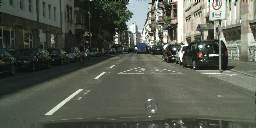
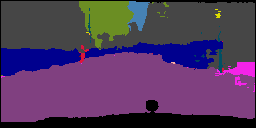
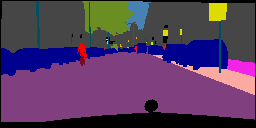

In [12]:
# Train less layer with augmentation
import time
torch.cuda.empty_cache()
time.sleep(5)

model = Unetupgrade()
    
# Train the passthrough network
print("Testing training process...")
for i in range(10):
    # Re-create dataset and re-train
    ds_split = {
        name:CityscapesDataset(os.path.join(dir_input_pp, name), os.path.join(dir_truth_pp, name), sample_size, classes, i)    # Seperate 2 elements by : (claim operator)
        for name in ("train", "val", "test")    # Claim the variable name belongs to object CityscapeDataset first and then create when the values are assigned 
    }
    trainer = Trainer(model, ds_split)
    trainer.fit(epochs=2, batch_size=10) 

# Draw a random sample
input, truth = random.choice(ds_split["val"])

# Push through our network
model = model.cpu()
output = model(input.unsqueeze(0))

# Display the input, output and truth tensors
template_table = '<table><thead><tr><th>Tensor</th><th>Shape</th><th>Image</th></tr></thead><tbody>{0}</tbody></table>'
template_row = '<tr><td>{0}</td><td>{1}</td><td><img src="data:image/png;base64,{2}"/></td></tr>'

input_img = TF.to_pil_image(input)
output_img = ds_split["val"].to_image(ds_split["val"].masks_to_indices(output).squeeze(0))
truth_img = ds_split["val"].to_image(truth)

rows = []
for name, tensor, img in [('Input', input, input_img), ('Output', output, output_img), ('Target', truth, truth_img)]:
    with BytesIO() as b: 
        img.save(b, format='png')
        rows.append(template_row.format(name, list(tensor.shape), b64encode(b.getvalue()).decode('utf-8')))

# Render HTML table
table = template_table.format(''.join(rows))
display(HTML(table))

In [30]:
#Recursive solution, less layer and augmentation
import torch.nn.functional as F


class ConvRes(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(ConvRes, self).__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3,padding=1)
       # self.conv2 = nn.Conv2d(out_ch, out_ch, 3,padding=1)
        self.conv2 = nn.Sequential(
             nn.Conv2d(in_ch, out_ch, 3, padding=1),
             nn.BatchNorm2d(out_ch), 
             nn.ReLU(inplace=True),
             nn.Conv2d(out_ch, out_ch, 3, padding=1),
             nn.BatchNorm2d(out_ch),
             #nn.ReLU(inplace=True)          
         )
 
    def forward(self, input):
        res = F.relu(self.conv1(input))
        out = self.conv2(input) +res
        out = F.relu(out)
        #out2 += res
        return out



    
class UnetupgradeRes(nn.Module):
    def __init__(self, in_ch=3, out_ch=30):
        super(UnetupgradeRes, self).__init__()
        self.conv1 = ConvRes(in_ch, 64)#(256*128*3=>256*128*64)
        self.pool1 = nn.MaxPool2d(2)#(256*128*64=>128*64*64)
        self.conv2 = ConvRes(64, 128)#(128*64*64=>128*64*128)
        self.pool2 = nn.MaxPool2d(2)#128*64*128=>64*32*128
        self.conv3 = ConvRes(128, 256)#64*32*128=>64*32*256
        self.pool3 = nn.MaxPool2d(2)#64*32*256=>32*16*256
        self.conv4 = ConvRes(256, 1024)#32*16*256=>32*16*1024
        
        #self.pool4 = nn.MaxPool2d(2)#32*16*512=>16*8*512
        #self.conv5 = DoubleConv(512, 1024)#16*8*512=>16*8*1024
        ################
        self.up6 = nn.ConvTranspose2d(1024, 256, 2, stride=2)#32*16*1024=>64*32*256
        self.conv6 = ConvRes(512, 256)   
        self.up7 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv7 = ConvRes(256, 128)
        self.up8 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv8 = ConvRes(128, 64)
        #self.up9 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        #self.conv9 = DoubleConv(128, 64)
        self.conv9 = nn.Conv2d(64, out_ch, 1)
 
    def forward(self, x):
        c1 = self.conv1(x)
        p1 = self.pool1(c1)
        c2 = self.conv2(p1)
        p2 = self.pool2(c2)
        c3 = self.conv3(p2)#64*32*256
        p3 = self.pool3(c3)
        c4 = self.conv4(p3)
        #p4 = self.pool4(c4)
        #c5 = self.conv5(p4)
        up_6 = self.up6(c4)#32*16*1024=>64*32*256
        merge6 = torch.cat([up_6, c3], dim=1)#64*32*256 + 64*32*256=64*32*512
        c6 = self.conv6(merge6) #64*32*512=>64*32*256
        up_7 = self.up7(c6)#64*32*256=>128*64*128
        merge7 = torch.cat([up_7, c2], dim=1)#128*64*128+128*64*128=128*64*256
        c7 = self.conv7(merge7)#128*64*256=>128*64*128
        up_8 = self.up8(c7)#128*64*128=>256*128*64
        merge8 = torch.cat([up_8, c1], dim=1)#256*128*64+256*128*64=256*128*128
        c8 = self.conv8(merge8)#256*128*128=>256*128*64
        #up_9 = self.up9(c8)
        #merge9 = torch.cat([up_9, c1], dim=1)
        #c9 = self.conv9(merge9)
        c10 = self.conv9(c8)#256*128*64=>256*128*30
        out = c10
        return out

Testing training process...
cuda
Epoch 1


Validation: 100%|██████████████| 500/500 [00:12<00:00, 39.32it/s, accuracy=tensor(0.5917, device='cuda:0'), loss=0.819]

Validation loss is 0.018943124532699585, validation accuracy is 0.5435353517532349
Epoch 2



Validation: 100%|███████████████| 500/500 [00:12<00:00, 39.40it/s, accuracy=tensor(0.7215, device='cuda:0'), loss=0.58]

Validation loss is 0.014911720907688141, validation accuracy is 0.6581422090530396
cuda
Epoch 1



Validation: 100%|██████████████| 500/500 [00:12<00:00, 39.32it/s, accuracy=tensor(0.7697, device='cuda:0'), loss=0.467]

Validation loss is 0.012522901856899263, validation accuracy is 0.7026768326759338
Epoch 2



Validation: 100%|██████████████| 500/500 [00:12<00:00, 38.93it/s, accuracy=tensor(0.7578, device='cuda:0'), loss=0.478]


Validation loss is 0.012424912524223328, validation accuracy is 0.6970129013061523
cuda
Epoch 1


Validation: 100%|██████████████| 500/500 [00:13<00:00, 38.30it/s, accuracy=tensor(0.7690, device='cuda:0'), loss=0.463]

Validation loss is 0.01230761742591858, validation accuracy is 0.7073118686676025
Epoch 2



Validation: 100%|██████████████| 500/500 [00:12<00:00, 38.57it/s, accuracy=tensor(0.7989, device='cuda:0'), loss=0.387]

Validation loss is 0.011199832272529601, validation accuracy is 0.7346453666687012
cuda
Epoch 1



Validation: 100%|██████████████| 500/500 [00:13<00:00, 38.36it/s, accuracy=tensor(0.8046, device='cuda:0'), loss=0.389]

Validation loss is 0.010512201595306397, validation accuracy is 0.731598436832428
Epoch 2



Validation: 100%|██████████████| 500/500 [00:13<00:00, 38.26it/s, accuracy=tensor(0.7988, device='cuda:0'), loss=0.405]


Validation loss is 0.010997804522514342, validation accuracy is 0.735694408416748
cuda
Epoch 1


Validation: 100%|██████████████| 500/500 [00:13<00:00, 38.45it/s, accuracy=tensor(0.8035, device='cuda:0'), loss=0.399]

Validation loss is 0.010218172359466553, validation accuracy is 0.744983971118927
Epoch 2



Validation: 100%|██████████████| 500/500 [00:13<00:00, 38.41it/s, accuracy=tensor(0.8006, device='cuda:0'), loss=0.403]


Validation loss is 0.011537288904190065, validation accuracy is 0.7277628779411316


Tensor,Shape,Image
Input,"[3, 128, 256]",
Output,"[1, 30, 128, 256]",
Target,"[128, 256]",

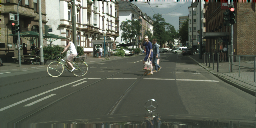
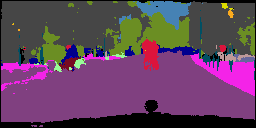
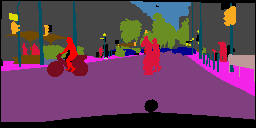

In [31]:
# #Recursive solution,less layer and augmentation
import time
torch.cuda.empty_cache()
time.sleep(2)

model = UnetupgradeRes()
    
# Train the passthrough network
print("Testing training process...")
for i in range(5):
    # Re-create dataset and re-train
    ds_split = {
        name:CityscapesDataset(os.path.join(dir_input_pp, name), os.path.join(dir_truth_pp, name), sample_size, classes, 0)    # Seperate 2 elements by : (claim operator)
        for name in ("train", "val", "test")    # Claim the variable name belongs to object CityscapeDataset first and then create when the values are assigned 
    }
    trainer = Trainer(model, ds_split)
    trainer.fit(epochs=2, batch_size=10)

# Draw a random sample
input, truth = random.choice(ds_split["val"])

# Push through our network
model = model.cpu()
output = model(input.unsqueeze(0))

# Display the input, output and truth tensors
template_table = '<table><thead><tr><th>Tensor</th><th>Shape</th><th>Image</th></tr></thead><tbody>{0}</tbody></table>'
template_row = '<tr><td>{0}</td><td>{1}</td><td><img src="data:image/png;base64,{2}"/></td></tr>'

input_img = TF.to_pil_image(input)
output_img = ds_split["val"].to_image(ds_split["val"].masks_to_indices(output).squeeze(0))
truth_img = ds_split["val"].to_image(truth)

rows = []
for name, tensor, img in [('Input', input, input_img), ('Output', output, output_img), ('Target', truth, truth_img)]:
    with BytesIO() as b: 
        img.save(b, format='png')
        rows.append(template_row.format(name, list(tensor.shape), b64encode(b.getvalue()).decode('utf-8')))

# Render HTML table
table = template_table.format(''.join(rows))
display(HTML(table))

In [16]:
#Recursive solution with normal Unet and augmentation
import torch.nn.functional as F

class ConvRes1(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(ConvRes1, self).__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3,padding=1)
       # self.conv2 = nn.Conv2d(out_ch, out_ch, 3,padding=1)
        self.conv2 = nn.Sequential(
             nn.Conv2d(in_ch, out_ch, 3, padding=1),
             nn.BatchNorm2d(out_ch), 
             nn.ReLU(inplace=True),
             nn.Conv2d(out_ch, out_ch, 3, padding=1),
             nn.BatchNorm2d(out_ch),
             #nn.ReLU(inplace=True)          
         )
 
    def forward(self, input):
        res = F.relu(self.conv1(input))
        out = self.conv2(input) +res
        out = F.relu(out)
        #out2 += res
        return out


    
class FullUnetRes(nn.Module):
    def __init__(self, in_ch=3, out_ch=30):
        super(FullUnetRes, self).__init__()
        self.conv1 = ConvRes1(in_ch, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = ConvRes1(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = ConvRes1(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.conv4 = ConvRes1(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        self.conv5 = ConvRes1(512, 1024)#16*8*1024
        ###############
        self.up6 = nn.ConvTranspose2d(1024, 512, 2, stride=2)#16*8*1024=>32*16*512
        self.conv6 = ConvRes1(1024, 512)
        self.up7 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv7 = ConvRes1(512, 256)
        self.up8 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv8 = ConvRes1(256, 128)
        self.up9 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv9 = ConvRes1(128, 64)
        self.conv10 = nn.Conv2d(64, out_ch, 1)
 
    def forward(self, x):
        c1 = self.conv1(x)
        p1 = self.pool1(c1)
        c2 = self.conv2(p1)
        p2 = self.pool2(c2)
        c3 = self.conv3(p2)
        p3 = self.pool3(c3)
        c4 = self.conv4(p3)
        p4 = self.pool4(c4)
        c5 = self.conv5(p4)
        up_6 = self.up6(c5)#32*16*512
        merge6 = torch.cat([up_6, c4], dim=1)#32*16*512+32*16*512=32*16*1024
        c6 = self.conv6(merge6)#32*16*1024=>32*16*512
        up_7 = self.up7(c6)
        merge7 = torch.cat([up_7, c3], dim=1)
        c7 = self.conv7(merge7)
        up_8 = self.up8(c7)
        merge8 = torch.cat([up_8, c2], dim=1)
        c8 = self.conv8(merge8)
        up_9 = self.up9(c8)
        merge9 = torch.cat([up_9, c1], dim=1)
        c9 = self.conv9(merge9)
        c10 = self.conv10(c9)
        out = c10
        return out

Testing training process...
cuda
Epoch 1


Validation: 100%|██████████████| 500/500 [00:13<00:00, 36.61it/s, accuracy=tensor(0.6596, device='cuda:0'), loss=0.732]


Validation loss is 0.01741804927587509, validation accuracy is 0.6107892394065857
Epoch 2


Validation: 100%|██████████████| 500/500 [00:13<00:00, 37.34it/s, accuracy=tensor(0.7204, device='cuda:0'), loss=0.599]


Validation loss is 0.016328450250625612, validation accuracy is 0.6288684606552124
cuda
Epoch 1


Validation: 100%|███████████████| 500/500 [00:13<00:00, 37.69it/s, accuracy=tensor(0.7493, device='cuda:0'), loss=0.53]


Validation loss is 0.013547404766082764, validation accuracy is 0.6845637559890747
Epoch 2


Validation: 100%|██████████████| 500/500 [00:13<00:00, 37.90it/s, accuracy=tensor(0.7615, device='cuda:0'), loss=0.472]


Validation loss is 0.01415289431810379, validation accuracy is 0.6675772070884705
cuda
Epoch 1


Validation: 100%|██████████████| 500/500 [00:13<00:00, 37.99it/s, accuracy=tensor(0.8008, device='cuda:0'), loss=0.418]


Validation loss is 0.011859213733673095, validation accuracy is 0.7140462398529053
Epoch 2


Validation: 100%|██████████████| 500/500 [00:13<00:00, 37.71it/s, accuracy=tensor(0.7506, device='cuda:0'), loss=0.483]


Validation loss is 0.013059900140762328, validation accuracy is 0.6894755363464355
cuda
Epoch 1


Validation: 100%|██████████████| 500/500 [00:13<00:00, 37.56it/s, accuracy=tensor(0.7329, device='cuda:0'), loss=0.471]


Validation loss is 0.011609401786327363, validation accuracy is 0.7077116966247559
Epoch 2


Validation: 100%|███████████████| 500/500 [00:13<00:00, 37.18it/s, accuracy=tensor(0.8024, device='cuda:0'), loss=0.39]


Validation loss is 0.010541977512836455, validation accuracy is 0.7346729040145874
cuda
Epoch 1


Validation: 100%|██████████████| 500/500 [00:13<00:00, 36.80it/s, accuracy=tensor(0.7988, device='cuda:0'), loss=0.371]


Validation loss is 0.01003591834306717, validation accuracy is 0.7471888661384583
Epoch 2


Validation: 100%|██████████████| 500/500 [00:13<00:00, 36.96it/s, accuracy=tensor(0.7918, device='cuda:0'), loss=0.393]


Validation loss is 0.010398380005359649, validation accuracy is 0.7362372279167175
cuda
Epoch 1


Validation: 100%|██████████████| 500/500 [00:13<00:00, 37.17it/s, accuracy=tensor(0.7990, device='cuda:0'), loss=0.385]


Validation loss is 0.01039247019290924, validation accuracy is 0.7487148642539978
Epoch 2


Validation: 100%|██████████████| 500/500 [00:13<00:00, 37.19it/s, accuracy=tensor(0.8091, device='cuda:0'), loss=0.343]


Validation loss is 0.009442095482349396, validation accuracy is 0.7572802305221558
cuda
Epoch 1


Validation: 100%|██████████████| 500/500 [00:13<00:00, 37.21it/s, accuracy=tensor(0.7997, device='cuda:0'), loss=0.374]


Validation loss is 0.009447400557994843, validation accuracy is 0.7520179748535156
Epoch 2


Validation: 100%|██████████████| 500/500 [00:13<00:00, 36.63it/s, accuracy=tensor(0.8151, device='cuda:0'), loss=0.359]


Validation loss is 0.009340399742126465, validation accuracy is 0.7531733512878418
cuda
Epoch 1


Validation: 100%|███████████████| 500/500 [00:13<00:00, 36.93it/s, accuracy=tensor(0.8023, device='cuda:0'), loss=0.37]


Validation loss is 0.010318847703933716, validation accuracy is 0.7499403953552246
Epoch 2


Validation: 100%|██████████████| 500/500 [00:13<00:00, 37.02it/s, accuracy=tensor(0.7923, device='cuda:0'), loss=0.394]


Validation loss is 0.009437939596176148, validation accuracy is 0.753629207611084
cuda
Epoch 1


Validation: 100%|██████████████| 500/500 [00:13<00:00, 36.28it/s, accuracy=tensor(0.7978, device='cuda:0'), loss=0.373]


Validation loss is 0.009215989595651626, validation accuracy is 0.7623839974403381
Epoch 2


Validation: 100%|██████████████| 500/500 [00:13<00:00, 36.91it/s, accuracy=tensor(0.8132, device='cuda:0'), loss=0.334]


Validation loss is 0.009476012170314789, validation accuracy is 0.747055172920227
cuda
Epoch 1


Validation: 100%|██████████████| 500/500 [00:13<00:00, 36.64it/s, accuracy=tensor(0.8269, device='cuda:0'), loss=0.319]


Validation loss is 0.009522972965240479, validation accuracy is 0.7722218632698059
Epoch 2


Validation: 100%|██████████████| 500/500 [00:13<00:00, 36.24it/s, accuracy=tensor(0.8185, device='cuda:0'), loss=0.328]


Validation loss is 0.00961814295053482, validation accuracy is 0.7642214894294739
cuda
Epoch 1


Validation: 100%|██████████████| 500/500 [00:13<00:00, 36.88it/s, accuracy=tensor(0.8136, device='cuda:0'), loss=0.369]


Validation loss is 0.009132385390996933, validation accuracy is 0.7654967308044434
Epoch 2


Validation: 100%|██████████████| 500/500 [00:13<00:00, 37.15it/s, accuracy=tensor(0.8251, device='cuda:0'), loss=0.327]


Validation loss is 0.008854235845804215, validation accuracy is 0.7722342014312744
cuda
Epoch 1


Validation: 100%|██████████████| 500/500 [00:13<00:00, 37.30it/s, accuracy=tensor(0.8222, device='cuda:0'), loss=0.339]


Validation loss is 0.009352591794729232, validation accuracy is 0.7682713270187378
Epoch 2


Validation: 100%|██████████████| 500/500 [00:13<00:00, 37.09it/s, accuracy=tensor(0.8369, device='cuda:0'), loss=0.302]


Validation loss is 0.008902572506666184, validation accuracy is 0.7794060111045837
cuda
Epoch 1


Validation: 100%|██████████████| 500/500 [00:13<00:00, 36.98it/s, accuracy=tensor(0.8236, device='cuda:0'), loss=0.342]


Validation loss is 0.00926653572320938, validation accuracy is 0.7609257102012634
Epoch 2


Validation: 100%|██████████████| 500/500 [00:13<00:00, 37.27it/s, accuracy=tensor(0.8316, device='cuda:0'), loss=0.325]


Validation loss is 0.009119994086027145, validation accuracy is 0.77773517370224
cuda
Epoch 1


Validation: 100%|██████████████| 500/500 [00:13<00:00, 37.02it/s, accuracy=tensor(0.8223, device='cuda:0'), loss=0.328]


Validation loss is 0.008694485986232757, validation accuracy is 0.7756204605102539
Epoch 2


Validation: 100%|██████████████| 500/500 [00:13<00:00, 37.25it/s, accuracy=tensor(0.8313, device='cuda:0'), loss=0.312]


Validation loss is 0.008884268760681152, validation accuracy is 0.7779178619384766
cuda
Epoch 1


Validation: 100%|██████████████| 500/500 [00:13<00:00, 37.16it/s, accuracy=tensor(0.8225, device='cuda:0'), loss=0.344]


Validation loss is 0.008820339947938918, validation accuracy is 0.7743144631385803
Epoch 2


Validation: 100%|██████████████| 500/500 [00:13<00:00, 37.17it/s, accuracy=tensor(0.8371, device='cuda:0'), loss=0.309]


Validation loss is 0.008293699437379837, validation accuracy is 0.788493812084198


Tensor,Shape,Image
Input,"[3, 128, 256]",
Output,"[1, 30, 128, 256]",
Target,"[128, 256]",

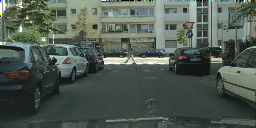
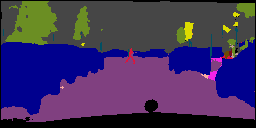
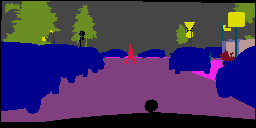

In [17]:
#Recursive solution with normal Unet and augmentation
import time
torch.cuda.empty_cache()
time.sleep(2)

model = FullUnetRes()
    
# Train the passthrough network
print("Testing training process...")
for i in range(15):
    # Re-create dataset and re-train
    ds_split = {
        name:CityscapesDataset(os.path.join(dir_input_pp, name), os.path.join(dir_truth_pp, name), sample_size, classes, i)    # Seperate 2 elements by : (claim operator)
        for name in ("train", "val", "test")    # Claim the variable name belongs to object CityscapeDataset first and then create when the values are assigned 
    }
    trainer = Trainer(model, ds_split)
    trainer.fit(epochs=2, batch_size=10)
# Draw a random sample
input, truth = random.choice(ds_split["val"])

# Push through our network
model = model.cpu()
output = model(input.unsqueeze(0))

# Display the input, output and truth tensors
template_table = '<table><thead><tr><th>Tensor</th><th>Shape</th><th>Image</th></tr></thead><tbody>{0}</tbody></table>'
template_row = '<tr><td>{0}</td><td>{1}</td><td><img src="data:image/png;base64,{2}"/></td></tr>'

input_img = TF.to_pil_image(input)
output_img = ds_split["val"].to_image(ds_split["val"].masks_to_indices(output).squeeze(0))
truth_img = ds_split["val"].to_image(truth)

rows = []
for name, tensor, img in [('Input', input, input_img), ('Output', output, output_img), ('Target', truth, truth_img)]:
    with BytesIO() as b: 
        img.save(b, format='png')
        rows.append(template_row.format(name, list(tensor.shape), b64encode(b.getvalue()).decode('utf-8')))

# Render HTML table
table = template_table.format(''.join(rows))
display(HTML(table))

## Troubleshooting

###### There is not enough memory on my GPU to define any practical network.
We already downsampled the images in the preprocessing section of the notebook. Before downsampling further, try reducing your `batch_size` on the `Trainer` class.

###### My assignment partner keeps overwriting my changes
Consider splitting up the notebook and your networks into multiple python files and using a Git repository for version control.

###### There is not enough memory on my PC to store the dataset
Connect a USB-drive and point the `dir_data` variable to this location.

_Created by Kurt Stolle, last modified 2021-03-14_